In [1]:
import pandas as pd
import numpy
import numpy as np
import statistics as st
from scipy.stats import mode, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from datetime import datetime, timedelta
from pmdarima import auto_arima
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, GRU, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [2]:
bnb_df = pd.read_csv("./BNB Historical Data.csv")
bnb_df

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2024,601.80,593.80,608.19,593.20,161.02K,1.35%
1,05/31/2024,593.80,594.99,598.89,590.10,175.98K,-0.20%
2,05/30/2024,594.99,595.69,601.80,586.60,233.89K,-0.10%
3,05/29/2024,595.59,601.69,603.59,593.29,219.96K,-1.01%
4,05/28/2024,601.69,603.80,605.48,594.29,294.76K,-0.35%
...,...,...,...,...,...,...,...
1915,03/05/2019,13.65,11.40,13.74,11.40,8.34M,19.61%
1916,03/04/2019,11.41,11.45,11.51,10.88,2.74M,-0.29%
1917,03/03/2019,11.45,11.75,11.86,11.20,2.86M,-2.58%
1918,03/02/2019,11.75,11.35,11.80,10.83,3.89M,3.56%


### Pre-processing Data

In [3]:
print(bnb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1920 non-null   object 
 1   Price     1920 non-null   float64
 2   Open      1920 non-null   float64
 3   High      1920 non-null   float64
 4   Low       1920 non-null   float64
 5   Vol.      1920 non-null   object 
 6   Change %  1920 non-null   object 
dtypes: float64(4), object(3)
memory usage: 105.1+ KB
None


* Định dạng lại cột `Date` để nó trở thành dạng `datetime`
* Xử lý và chuyển đổi kiểu dữ liệu của cột `Vol.` và `Change %` thành kiểu float

In [4]:
bnb_df['Date'] = pd.to_datetime(bnb_df['Date'])
bnb_df['Vol.'] = bnb_df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').fillna('0')
bnb_df['Vol.'] = bnb_df['Vol.'].astype(float)
bnb_df['Change %'] = bnb_df['Change %'].str.replace('%', '').astype(float)
bnb_df.reset_index(drop=True)
bnb_df.set_index('Date', inplace=True)
bnb_df.sort_index(ascending=True, inplace=True)
bnb_df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-03-01,11.35,10.27,11.55,10.24,4020000.0,10.45
2019-03-02,11.75,11.35,11.80,10.83,3890000.0,3.56
2019-03-03,11.45,11.75,11.86,11.20,2860000.0,-2.58
2019-03-04,11.41,11.45,11.51,10.88,2740000.0,-0.29
2019-03-05,13.65,11.40,13.74,11.40,8340000.0,19.61
...,...,...,...,...,...,...
2024-05-28,601.69,603.80,605.48,594.29,294760.0,-0.35
2024-05-29,595.59,601.69,603.59,593.29,219960.0,-1.01
2024-05-30,594.99,595.69,601.80,586.60,233890.0,-0.10


In [5]:
missing_values = bnb_df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [6]:
print(bnb_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     1920 non-null   float64
 1   Open      1920 non-null   float64
 2   High      1920 non-null   float64
 3   Low       1920 non-null   float64
 4   Vol.      1920 non-null   float64
 5   Change %  1920 non-null   float64
dtypes: float64(6)
memory usage: 105.0 KB
None


In [7]:
bnb_description = bnb_df.describe()
bnb_description

,Price,Open,High,Low,Vol.,Change %
count,1920.000000,1920.000000,1920.000000,1920.000000,1.920000e+03,1920.000000
mean,229.552547,229.245161,235.806146,222.272714,4.316261e+06,0.329344
std,184.430107,184.300217,189.692063,178.382323,2.135747e+07,4.891566
min,9.250000,9.250000,10.410000,6.500000,8.993000e+04,-44.080000
25%,27.030000,27.027500,27.807500,26.082500,5.633800e+05,-1.610000
50%,247.550000,247.055000,254.285000,242.050000,1.600000e+06,0.130000
75%,332.110000,331.345000,339.792500,322.325000,3.772500e+06,2.160000
max,676.560000,676.250000,690.870000,634.810000,3.995400e+08,69.990000


In [8]:
# Descriptive statistics for Price
print('More Price Statistics:')

print('Mode:', bnb_df['Price'].mode().values[0])
print('Standard Deviation:', bnb_df['Price'].std())
print('Variance:', bnb_df['Price'].var())
print('Kurtosis:', bnb_df['Price'].kurt())
print('Skewness:', bnb_df['Price'].skew())

More Price Statistics:
Mode: 23.01
Standard Deviation: 184.43010721388004
Variance: 34014.46444692328
Kurtosis: -0.8960616714167435
Skewness: 0.33018718587724455


##### Price by Date Plot

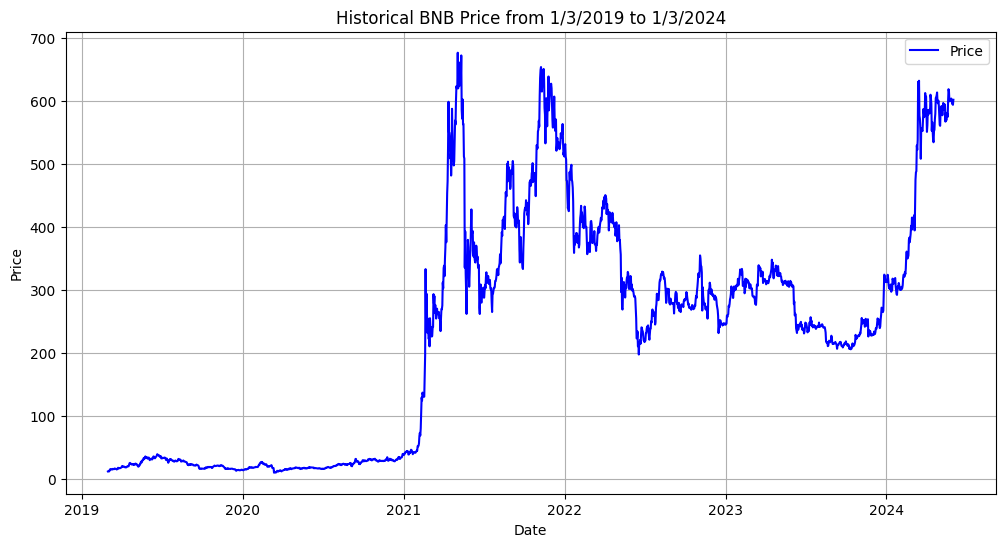

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(bnb_df['Price'], label='Price', color='b')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Historical BNB Price from 1/3/2019 to 1/3/2024')
plt.legend()
plt.grid(True)
plt.show()


##### Boxplot for Price

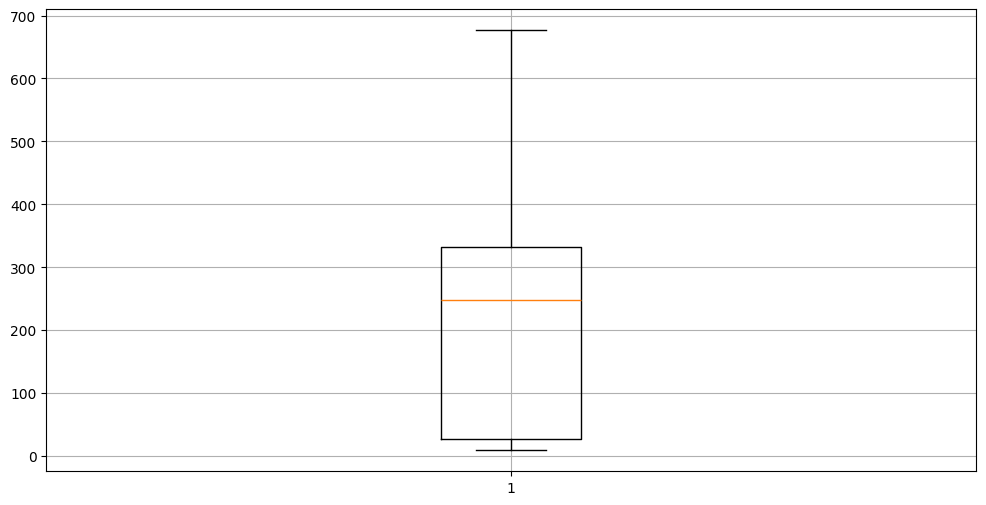

In [10]:
plt.figure(figsize=(12, 6))
plt.boxplot(bnb_df['Price'])
plt.grid()
plt.show()

### Parameter

In [11]:
window_size = 10
feature_dim = 5
test_size=0.2

# model params
lstm_neurons = 20
rnn_neurons = 20
epochs = 100
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

### Split data

In [12]:
train_ratio = 0.7
test_ratio = 0.3

In [13]:
train_data = int(len(bnb_df)*train_ratio)
test_data = train_data + int(len(bnb_df)*test_ratio)

print('train index: ',train_data)
print('test index: ',test_data)

train index:  1344
test index:  1920


In [14]:
train_df = bnb_df.iloc[:train_data]
test_df  = bnb_df[train_data:test_data]

print('train_df.shape: ',train_df.shape)
print('test_df.shape: ',test_df.shape)

train_df.shape:  (1344, 6)
test_df.shape:  (576, 6)


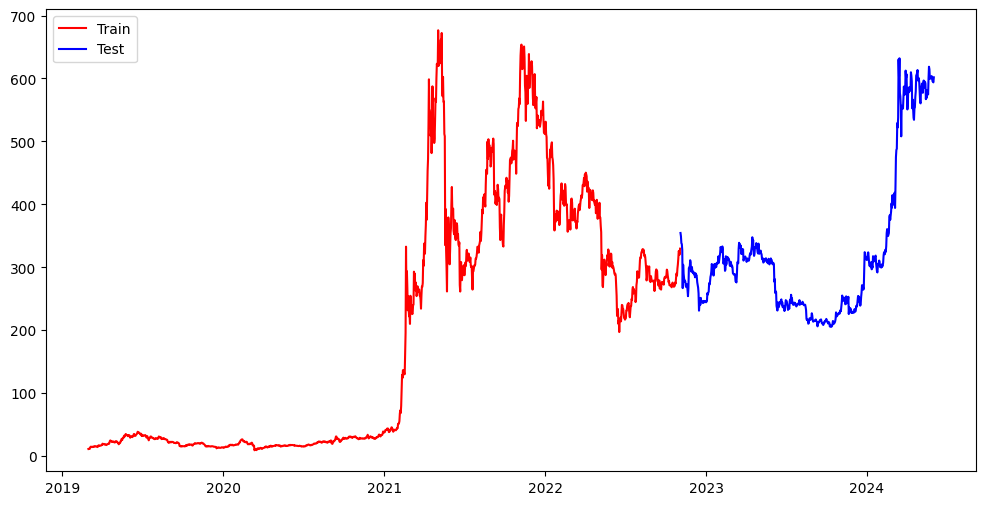

In [15]:
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(train_df).index.to_list(), pd.DataFrame(train_df['Price']), color='r', label='Train')
plt.plot(pd.DataFrame(test_df).index.to_list(),pd.DataFrame(test_df['Price']),color='b' ,label ='Test')
plt.legend()
plt.show()

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)

train_df_scaled = pd.DataFrame(train_df_scaled, index=train_df.index, columns=train_df.columns)
test_df_scaled = pd.DataFrame(test_df_scaled, index=test_df.index, columns=test_df.columns)

In [17]:
print('train_df_scaled shape: ',train_df_scaled.shape)
print('test_df_scaled shape: ',test_df_scaled.shape)

train_df_scaled shape:  (1344, 6)
test_df_scaled shape:  (576, 6)


In [18]:
# Define the target variable
target = 'Price'

In [19]:
# Split data into features and target
X_train = train_df_scaled.drop(columns=target).values
y_train = train_df_scaled[target]

X_test = test_df_scaled.drop(columns=target).values
y_test = test_df_scaled[target]

### Model Training

#### Linear Regression

In [20]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred_test_lr = model.predict(X_test)

##### Evaluate Linear Regression

In [21]:
# Evaluate model on test set
mape_test_lr = mean_absolute_percentage_error(y_test, y_pred_test_lr)
mae_test_lr = mean_absolute_error(y_test, y_pred_test_lr)
rmse_test_lr = root_mean_squared_error(y_test, y_pred_test_lr)

print("Test Set MAPE: ", mape_test_lr)
print("Test Set MAE: ", mae_test_lr)
print("Test Set RMSE: ", rmse_test_lr)

Test Set MAPE:  0.006625649426235931
Test Set MAE:  0.0032932208465291453
Test Set RMSE:  0.005769836245256641


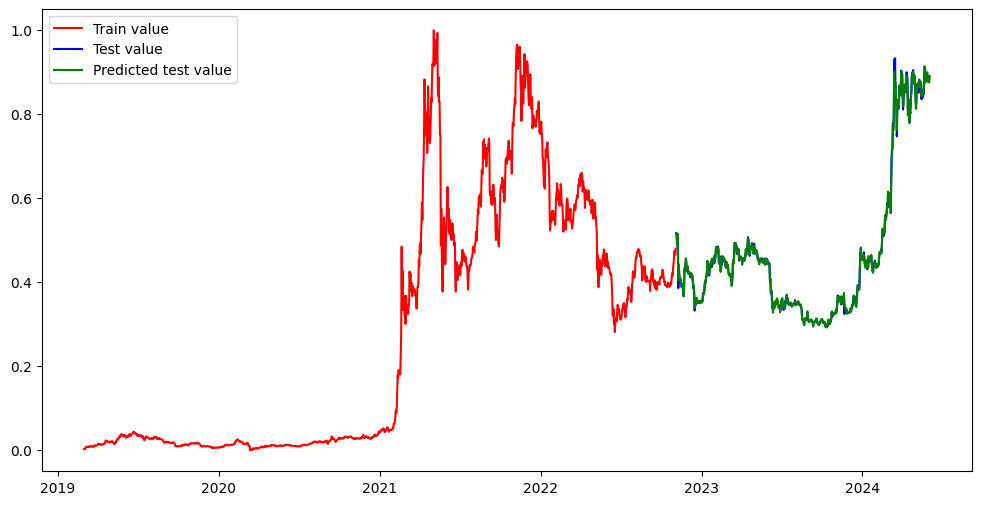

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_pred_test_lr.reshape(-1)), color='g', label='Predicted test value')
plt.legend()
plt.show()

#### ARIMA

In [23]:
y_train

Date
2019-03-01    0.003147
2019-03-02    0.003746
2019-03-03    0.003297
2019-03-04    0.003237
2019-03-05    0.006594
                ...   
2022-10-30    0.455935
2022-10-31    0.474352
2022-11-01    0.471520
2022-11-02    0.465975
2022-11-03    0.480077
Name: Price, Length: 1344, dtype: float64

In [24]:
stepwise_model = auto_arima(y_train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=1,
                            start_P=0, seasonal=False,
                            d=None, D=0, trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

print(stepwise_model.summary())

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6470.597, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6440.941, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6467.562, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6463.094, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6442.590, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6472.467, Time=2.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6473.698, Time=1.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6475.184, Time=1.86 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-6474.067, Time=2.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-6473.332, Time=1.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-6482.823, Time=8.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-6493.467, Time=6.60 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-6490.893, Time=1.64 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-6489.092, Time=9.56 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-6484.631, Time=8.00

In [25]:
y_pred_test_arima = stepwise_model.predict(n_periods=len(X_test))
mape_test_arima = mean_absolute_percentage_error(y_test, y_pred_test_arima)
mae_test_arima = mean_absolute_error(y_test, y_pred_test_arima)
rmse_test_arima = root_mean_squared_error(y_test, y_pred_test_arima)

print("Test Set MAPE: ", mape_test_arima)
print("Test Set MAE: ", mae_test_arima)
print("Test Set RMSE: ", rmse_test_arima)

Test Set MAPE:  0.41310192621173686
Test Set MAE:  0.16570443029675047
Test Set RMSE:  0.18542358849267448


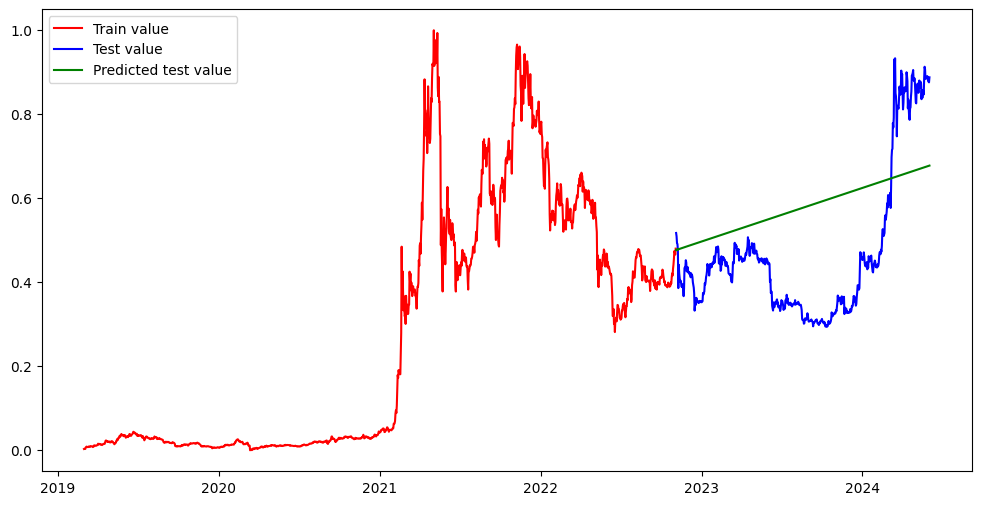

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_pred_test_arima), color='g', label='Predicted test value')
plt.legend()
plt.show()

#### GRU

In [27]:
X_train_GRU = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train_GRU = y_train.values


X_test_GRU = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test_GRU = y_test

In [28]:
# Xây dựng mô hình GRU
model_GRU = Sequential()
model_GRU.add(GRU(50, return_sequences=True, input_shape=(1, X_train_GRU.shape[2])))
model_GRU.add(GRU(50, return_sequences=False))
model_GRU.add(Dense(25))
model_GRU.add(Dense(1))

# Compile mô hình
model_GRU.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
history_GRU = model_GRU.fit(X_train_GRU, y_train_GRU, epochs=100, batch_size=64, verbose=1)

c:\Users\VU HOANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0798
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6000e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1793e-04 
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0321e-04 
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7328e-04 
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0915e-04 
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3209e-04 
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7535e-04 
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9210e-04 
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3609e-04 
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6936e-04 
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9350e-04 
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6359e-04 
Epoch 15/10

In [29]:
# Compile mô hình
model_GRU.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
# Dự đoán giá
test_predict_GRU = model_GRU.predict(X_test_GRU)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [31]:
mape_test_GRU = mean_absolute_percentage_error(y_test_GRU, test_predict_GRU)
mae_test_GRU = mean_absolute_error(y_test_GRU, test_predict_GRU)
rmse_test_GRU = root_mean_squared_error(y_test_GRU, test_predict_GRU)

print("Test Set MAPE: ", mape_test_GRU)
print("Test Set MAE: ", mae_test_GRU)
print("Test Set RMSE: ", rmse_test_GRU)

Test Set MAPE:  0.004692035043641267
Test Set MAE:  0.002362466160008416
Test Set RMSE:  0.004086830312996961


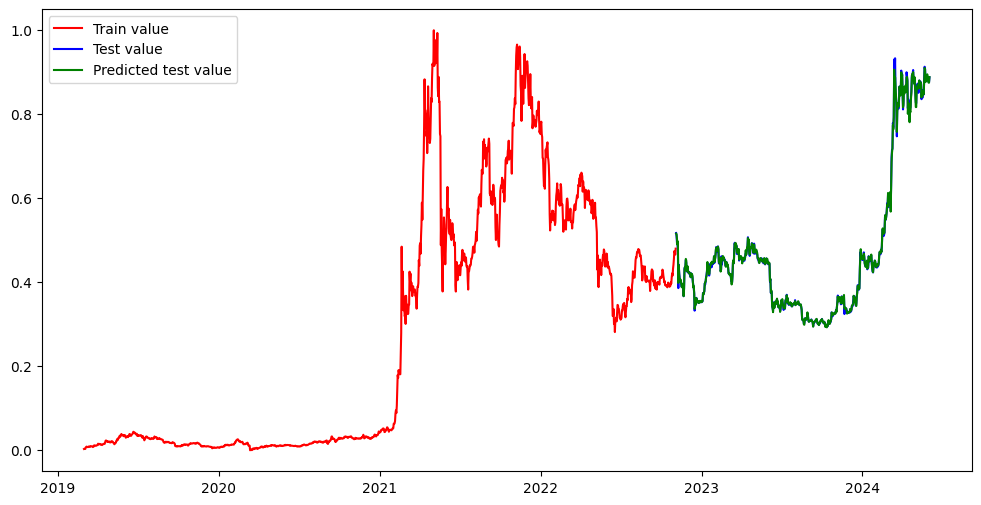

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(test_predict_GRU), color='g', label='Predicted test value')
plt.legend()
plt.show()

#### RNN

In [33]:
X_train_RNN = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train_RNN = y_train.values

X_test_RNN = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test_RNN = y_test.values

In [34]:
def build_RNN_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'): 
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=input_shape))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(optimizer='adam', loss='mse')

    model.compile(loss =loss, optimizer=optimizer)
    return model

In [35]:
model_RNN = build_RNN_model((X_train_RNN.shape[1],X_train_RNN.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

c:\Users\VU HOANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
history = model_RNN.fit(
    X_train_RNN, y_train_RNN, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [37]:
test_predict_RNN = model_RNN.predict(X_test_RNN)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


In [38]:
mape_test_RNN = mean_absolute_percentage_error(y_test_RNN, test_predict_RNN)
mae_test_RNN = mean_absolute_error(y_test_RNN, test_predict_RNN)
rmse_test_RNN = root_mean_squared_error(y_test_RNN, test_predict_RNN)

print("Test Set MAPE: ", mape_test_RNN)
print("Test Set MAE: ", mae_test_RNN)
print("Test Set RMSE: ", rmse_test_RNN)

Test Set MAPE:  0.006958382304540499
Test Set MAE:  0.003003694274376138
Test Set RMSE:  0.0037373826082200035


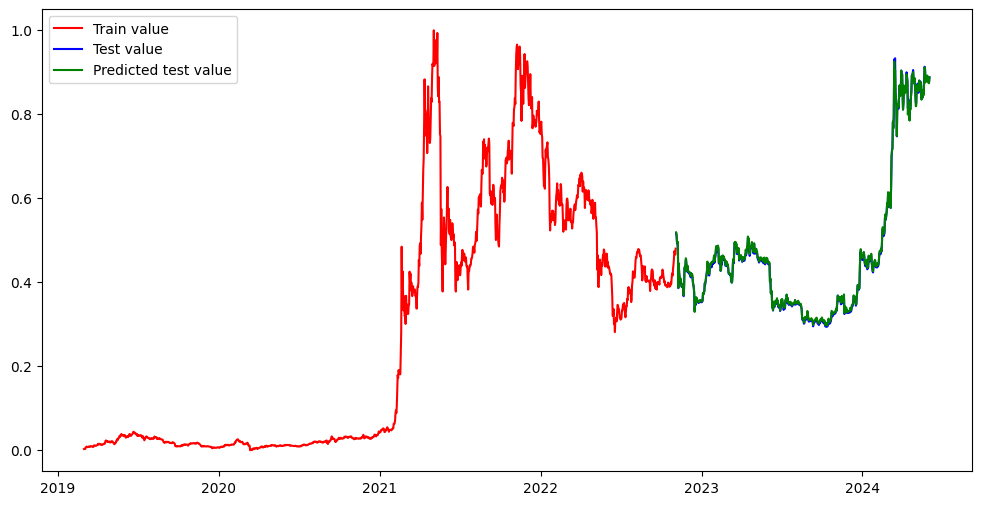

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(test_predict_RNN), color='g', label='Predicted test value')
plt.legend()
plt.show()

#### LSTM

In [40]:
X_train_LSTM = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train_LSTM = y_train.values

X_test_LSTM = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
y_test_LSTM = y_test.values

In [41]:
def build_lstm_model(input_shape, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [42]:
model_LSTM = build_lstm_model(
    (X_train_LSTM.shape[1],X_train_LSTM.shape[2]), output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

c:\Users\VU HOANG\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
history = model_LSTM.fit(
    X_train_LSTM, y_train_LSTM, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=True)

In [44]:
test_predict_LSTM = model_LSTM.predict(X_test_LSTM)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step


In [45]:
mape_test_LSTM = mean_absolute_percentage_error(y_test_LSTM, test_predict_LSTM)
mae_test_LSTM = mean_absolute_error(y_test_LSTM, test_predict_LSTM)
rmse_test_LSTM = root_mean_squared_error(y_test_LSTM, test_predict_LSTM)

print("Test Set MAPE: ", mape_test_LSTM)
print("Test Set MAE: ", mae_test_LSTM)
print("Test Set RMSE: ", rmse_test_LSTM)

Test Set MAPE:  0.021928675996393573
Test Set MAE:  0.012017184368635473
Test Set RMSE:  0.017032341889237548


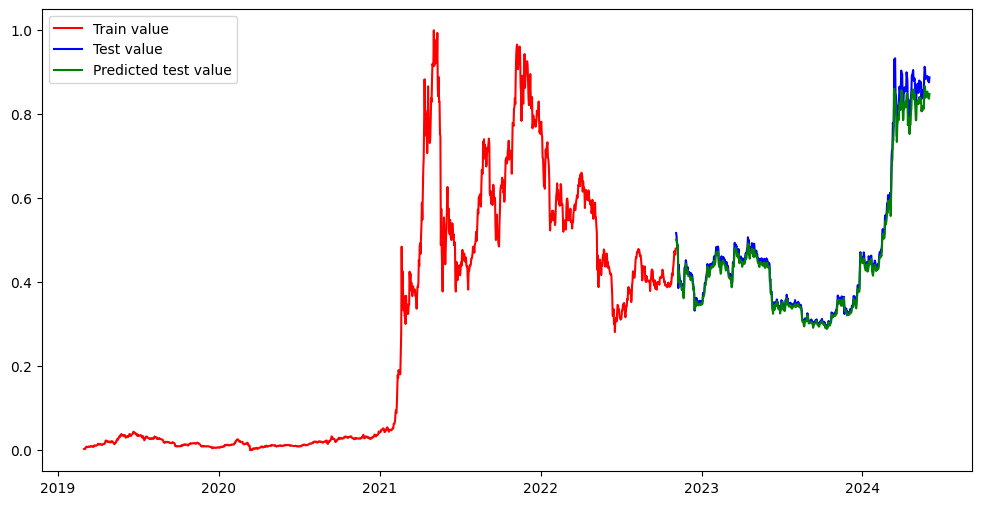

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DataFrame(y_train).index.to_list(),pd.DataFrame(y_train),color='red',label='Train value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(y_test), color='blue', label='Test value')
plt.plot(pd.DataFrame(y_test).index.to_list(), pd.DataFrame(test_predict_LSTM), color='g', label='Predicted test value')
plt.legend()
plt.show()

#### AutoFormer